## Minst Data Set

### Pytouch CNN，Res-net with GPU

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from DL_model import resnet34

In [2]:
print("PyTorch version: ", torch.__version__)  # 打印PyTorch版本
print("CUDA available : ", torch.cuda.is_available())  # 检查CUDA是否可用
print('There are %d GPU(s) available.' % torch.cuda.device_count())

PyTorch version:  2.4.1+cu124
CUDA available :  True
There are 1 GPU(s) available.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# 准备训练数据集
train_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=True,                       # 只使用训练数据集
    transform=transforms.ToTensor(),  # 用于对载入的图片数据进行类型转换，将之前构成 PIL 图片的数据转换成 Tensor 数据类型的变量，让 PyTorch 能够对其进行计算和处理。
    download=True
)

# 准备测试数据集
test_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=False,                      # 只使用训练数据集
    download=True
)

# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,              # 使用的数据集
    batch_size=64,                   # 批处理样本大小
    shuffle=False,                   # 每次迭代前不打乱数据
    num_workers=2,                 # 使用两个进程
)

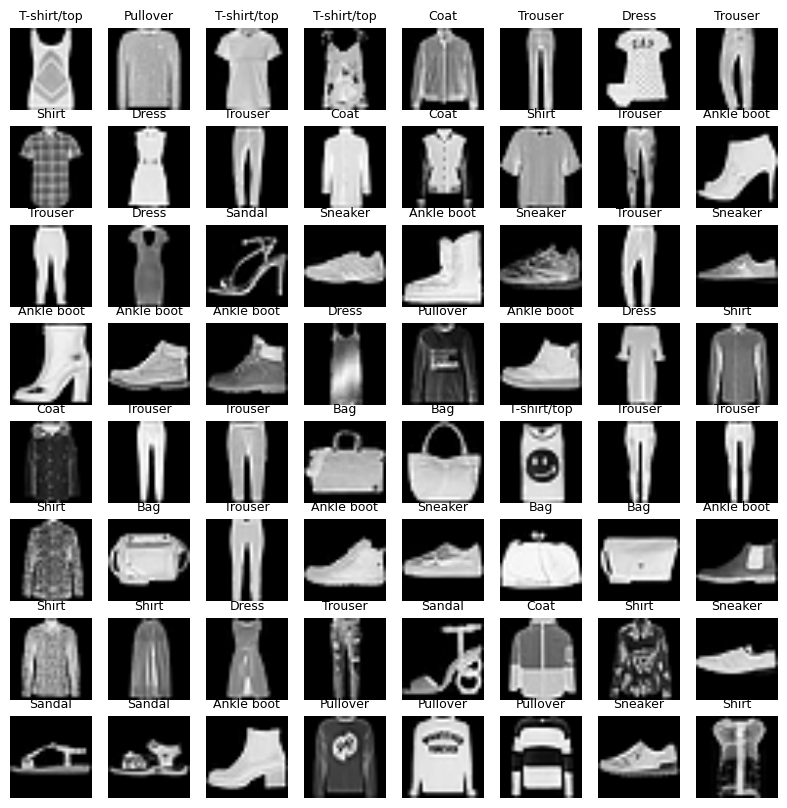

In [6]:
# 获取一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break

# 一个batch里的图片可视化
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
plt.figure(figsize=(10, 10))
for ii in np.arange(len(batch_y)):
    plt.subplot(8, 8, ii+1)
    plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray,interpolation='bilinear')
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.1)
plt.show()

# 测试集数据预处理
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)  # [10000, 1, 28, 28]
test_data_y = test_data.targets  # 测试集的标签 [10000]
test_data_x, test_data_y = test_data_x.to(device), test_data_y.to(device) #使用GPU训练 

In [15]:
### Choosing 
myconvnet = resnet34().to(device)

In [16]:
# 定义网络训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs):
    batch_num = len(traindataloader)                   # 获取训练总batch数
    train_batch_num = round(batch_num * train_rate)    # 按照train_rate比例进行训练集的划分
    
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    elapsed=[]
    since = time.time()
    
    # 训练轮次循环
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
 
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
 
        # 每个epoch有两个训练阶段
        for step, (b_x, b_y) in enumerate(traindataloader):
            b_x, b_y = b_x.to(device), b_y.to(device) #使用GPU训练 
            if step < train_batch_num:         # 训练集
                model.train()                  # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)  # 计算损失函数
                optimizer.zero_grad()          # 清空上一层梯度
                loss.backward()                # 反向传播
                optimizer.step()               # 更新优化器的学习率
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval()                   # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
 
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
 
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], train_acc_all[-1]))
 
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
 
        # 当精度创新高，复制模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        elapsed.append(time_use)
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
 
        # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch": range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all": train_acc_all,
              "val_acc_all": val_acc_all,
              }
    )
    return model, train_process, elapsed

In [17]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # 损失函数
myconvnet, train_process, elapsed= train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)

Epoch 0/24
0 Train Loss: 0.5232 Train Acc: 0.8096
0 Val Loss: 0.4091 Val Acc: 0.8574
Train and val complete in 0m 11s
Epoch 1/24
1 Train Loss: 0.3404 Train Acc: 0.8774
1 Val Loss: 0.3220 Val Acc: 0.8852
Train and val complete in 0m 21s
Epoch 2/24
2 Train Loss: 0.2948 Train Acc: 0.8927
2 Val Loss: 0.2892 Val Acc: 0.8976
Train and val complete in 0m 32s
Epoch 3/24
3 Train Loss: 0.2744 Train Acc: 0.9000
3 Val Loss: 0.3781 Val Acc: 0.8748
Train and val complete in 0m 42s
Epoch 4/24
4 Train Loss: 0.2490 Train Acc: 0.9086
4 Val Loss: 0.2946 Val Acc: 0.9002
Train and val complete in 0m 53s
Epoch 5/24
5 Train Loss: 0.2380 Train Acc: 0.9135
5 Val Loss: 0.2726 Val Acc: 0.9037
Train and val complete in 1m 3s
Epoch 6/24
6 Train Loss: 0.2231 Train Acc: 0.9185
6 Val Loss: 0.3178 Val Acc: 0.8963
Train and val complete in 1m 14s
Epoch 7/24
7 Train Loss: 0.2119 Train Acc: 0.9213
7 Val Loss: 0.2634 Val Acc: 0.9108
Train and val complete in 1m 25s
Epoch 8/24
8 Train Loss: 0.2053 Train Acc: 0.9259
8 Val L

In [32]:
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y.cpu(), pre_lab.cpu())
precision, recall, f1_score, _ = precision_recall_fscore_support(test_data_y.cpu(), pre_lab.cpu(), average='weighted')
print(f'Accuracy: {acc}')
print(f'Precision: {round(precision,4)}')
print(f'Recall: {recall}')
print(f'F1-Score: {round(f1_score,4)}')

Accuracy: 0.911
Precision: 0.9108
Recall: 0.911
F1-Score: 0.9104


C:\Users\Chuxu\AppData\Local\Temp\ipykernel_25256\862376706.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(train_process.epoch, elapsed, "ro-", c='green', label="Time")


Text(0, 0.5, 'Time')

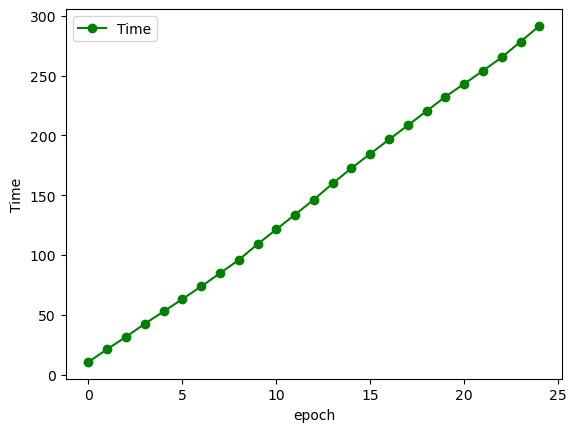

In [25]:
plt.plot(train_process.epoch, elapsed, "ro-", c='green', label="Time")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Time")

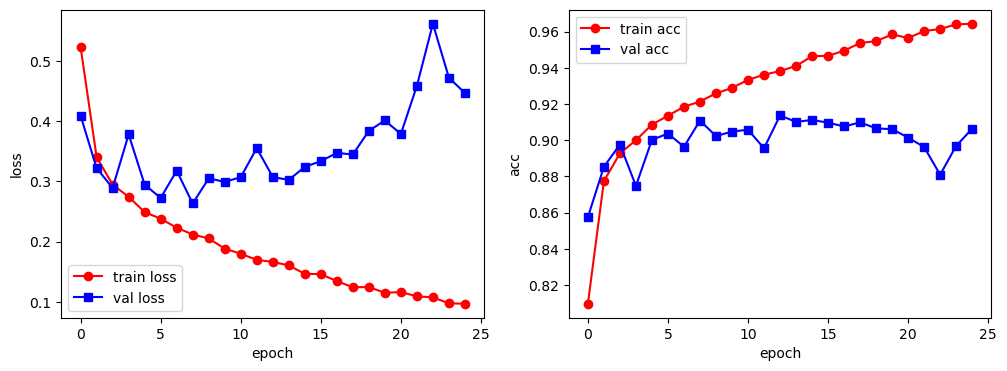

In [22]:
# 训练结果可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
 
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()
 

Text(95.72222222222221, 0.5, 'Predicted label')

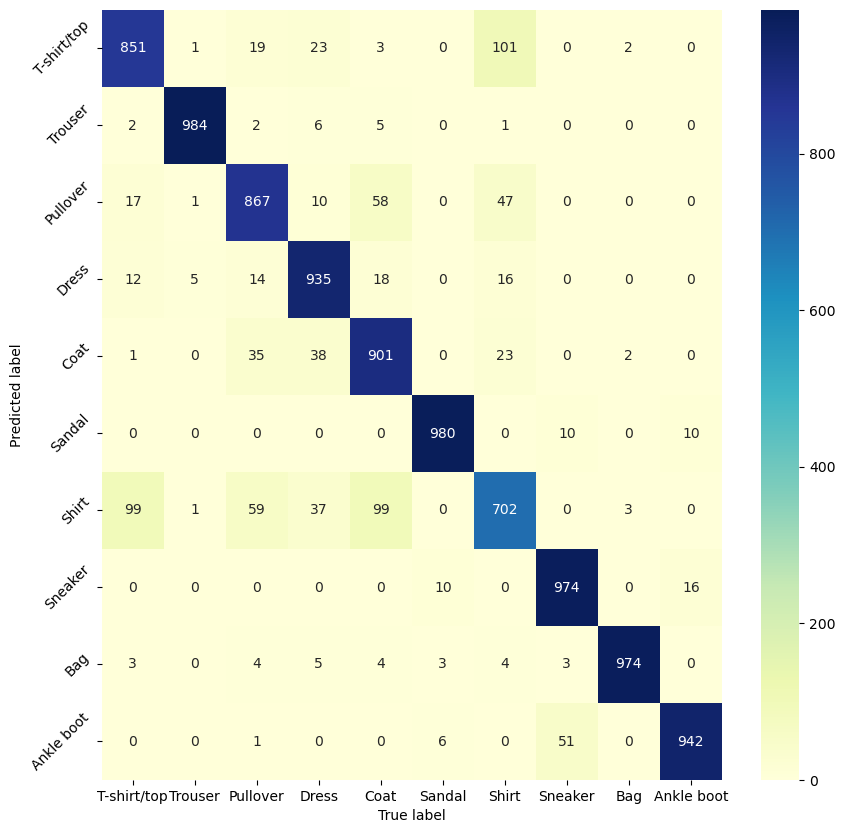

In [23]:
# 计算混淆矩阵可视化
con_mat = confusion_matrix(test_data_y.cpu(), pre_lab.cpu())
con_mat_df = pd.DataFrame(con_mat, index=class_label, columns=class_label)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(con_mat_df, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.set_ticklabels(class_label), rotation=0, ha='right')
heatmap.yaxis.set_ticklabels(heatmap.xaxis.set_ticklabels(class_label), rotation=45, ha='right')
plt.xlabel("True label")
plt.ylabel("Predicted label")